## Collect Data

In [12]:
import os
import re
import sqlite3
import json
from urllib.parse import urlparse
from collections import Counter

def extractRequests(entry, host):
    request = entry.get('request', {})
    if 'url' in request:
        request_url_parts = urlparse(request['url']).hostname.rsplit('.')
        if (request_url_parts[-1] == 'uk' and request_url_parts[-2] == 'co'):
            request_url = request_url_parts[-3] + '.' + request_url_parts[-2] + '.' + request_url_parts[-1]
        else:
            request_url = request_url_parts[-2] + '.' + request_url_parts[-1]

        if host not in request_url:
            return request_url

    return None

def processFolder(path):
    allDomains = []
    for filename in os.listdir(path):
        if filename.endswith('.har'):
            with open(os.path.join(path, filename), 'r', encoding='utf-8') as file:
                harData = json.load(file)
                entries = harData.get('log', {}).get('entries', [])
                for entry in entries:
                    match = re.search(r'(m|www)\.(.*)(\.har)', filename)
                    host = match.group(2) if match else None
                    
                    domain = extractRequests(entry, host)
                    if domain:
                        allDomains.append((domain, host, re.search(r'/(desktop|mobile)/', path).group(1)))
    return allDomains

dbConnect = sqlite3.connect('third_party_analysis.db')
dbCursor = dbConnect.cursor()

dbCursor.execute('''
    CREATE TABLE IF NOT EXISTS domain_counts (
        id INTEGER PRIMARY KEY,
        domain TEXT,
        host TEXT,
        type TEXT
    )
''')

paths = ['../archives/news/desktop/', '../archives/news/mobile/']

allDomains = []

for path in paths:
    allDomains += processFolder(path)

for domain, host, type in allDomains:
    dbCursor.execute('INSERT INTO domain_counts (domain, host, type) VALUES (?, ?, ?)', (domain, host, type))

dbConnect.commit()
dbConnect.close()

### Requests to third parties

In [14]:
conn = sqlite3.connect('third_party_analysis.db')
cursor = conn.cursor()

query = 'SELECT domain, COUNT(*) FROM domain_counts GROUP BY domain ORDER BY COUNT(*) DESC'

cursor.execute(query)

print("Domain\tCount")
print("----------------------------")
for domain, count in cursor.fetchall():
    print(f"{count}\t{domain}")

conn.close()

Domain	Count
----------------
1323	googlesyndication.com
1171	doubleclick.net
960	adsafeprotected.com
624	google.com
602	asadcdn.com
546	guim.co.uk
472	adobedtm.com
429	adnxs.com
415	rubiconproject.com
368	amazon-adsystem.com
309	gstatic.com
281	google-analytics.com
276	adform.net
245	outbrain.com
244	2mdn.net
239	taboola.com
234	googletagservices.com
229	idcdn.de
213	criteo.com
184	smartadserver.com
165	pubmatic.com
164	casalemedia.com
163	cxense.com
153	googletagmanager.com
151	cloudfront.net
148	teads.tv
145	chartbeat.net
143	ioam.de
139	yieldlab.net
136	glomex.com
135	xplosion.de
134	cnn.io
132	otto.de
126	presage.io
124	cookielaw.org
119	dwcdn.net
117	bounceexchange.com
112	googleapis.com
110	privacy-mgmt.com
109	piano.io
109	google.de
107	permutive.com
106	bildstatic.de
104	tinypass.com
104	openx.net
104	ampproject.org
101	moatads.com
101	doubleverify.com
100	adspirit.de
95	criteo.net
90	k5a.io
82	omnitagjs.com
82	dianomi.com
82	cleverpush.com
80	opencmp.net
79	the-ozone-project.

### Compare Requests by device type

In [19]:
conn = sqlite3.connect('third_party_analysis.db')
cursor = conn.cursor()

query = 'SELECT type, COUNT(*) FROM domain_counts GROUP BY type ORDER BY COUNT(*) DESC'

cursor.execute(query)

print("Count\tdevice type")
print("----------------------------")
for domain, count in cursor.fetchall():
    print(f"{count}\t{domain}")

conn.close()

Count	device type
----------------------------
10636	desktop
7822	mobile


### Compare amount of request of each website

In [29]:
conn = sqlite3.connect('third_party_analysis.db')
cursor = conn.cursor()

query = 'SELECT host, type, COUNT(*) FROM domain_counts GROUP BY host, type'

cursor.execute(query)
data3 = cursor.fetchall()

print("Count\tDevice Type\t\Host")
print("------------------------------------")
for host, type, count in data3:
    print(f"{count}\t{type}\t\t{host}")

conn.close()

Count	Device Type	\Host
------------------------------------
1477	desktop		bild.de
577	mobile		bild.de
628	desktop		cnn.com
982	mobile		cnn.com
1335	desktop		faz.net
533	mobile		faz.net
1672	desktop		merkur.de
1084	mobile		merkur.de
722	desktop		n-tv.de
924	mobile		n-tv.de
832	desktop		sueddeutsche.de
553	mobile		sueddeutsche.de
896	desktop		telegraph.co.uk
1373	mobile		telegraph.co.uk
1688	desktop		theguardian.com
579	mobile		theguardian.com
954	desktop		thehindu.com
819	mobile		thehindu.com
432	desktop		zeit.de
398	mobile		zeit.de


## Data Visualization

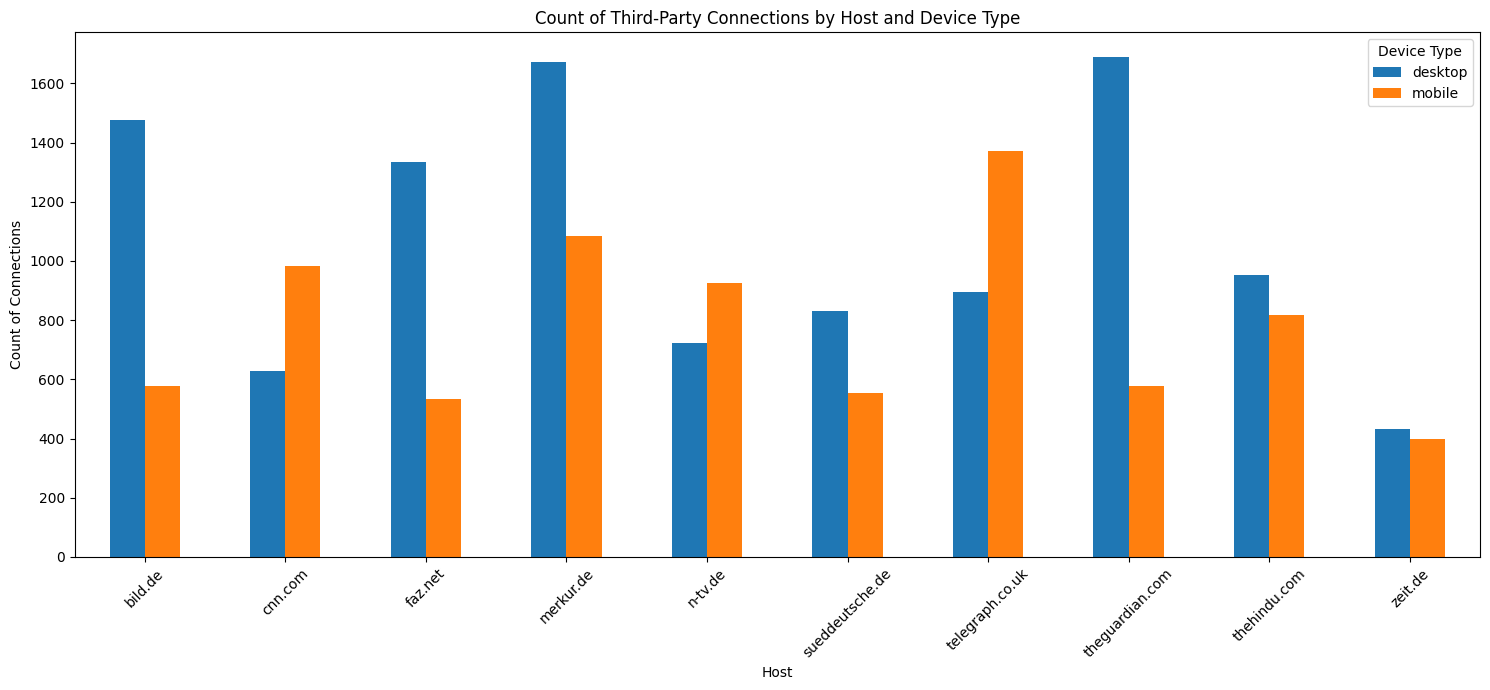

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data3, columns=['Host', 'Device Type', 'Count'])

pivot_df = df.pivot(index='Host', columns='Device Type', values='Count').fillna(0)

pivot_df.plot(kind='bar', figsize=(15, 7))

plt.title('Count of Third-Party Connections by Host and Device Type')
plt.xlabel('Host')
plt.ylabel('Count of Connections')
plt.xticks(rotation=45)
plt.legend(title='Device Type')
plt.tight_layout()

plt.show()